# Support Vector Machines from scratch

In [20]:
import os
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [21]:
X, y = make_blobs(n_samples=200, n_features=2, centers=2)

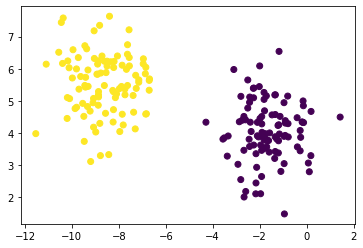

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y)